# VGGFace 2 and Lime Full Pipeline

We need to do five things:
1. Crop faces with MTCNN
2. Extract features with VGGFace2
3. Run Classifier
4. Fit all in one pipeline
5. Run Lime

In [1]:
import torch
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [108]:
path_to_img = r'./rohan.jpg'

img = Image.open(path_to_img)

img.size

(960, 960)

## Crop Face

In [109]:
from facenet_pytorch import MTCNN

from PIL import Image
import numpy as np

mtcnn = MTCNN(margin=20, keep_all=True, post_process=False, device='cuda:0')

In [110]:
faces = mtcnn(img)

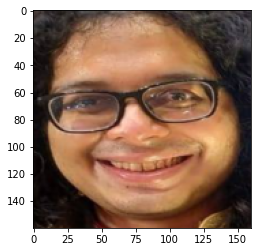

In [111]:
# Visualize
num_faces = len(faces)

if num_faces > 1:
    fig, axes = plt.subplots(1, len(faces))

    for face, ax in zip(faces, axes):
        ax.imshow(face.permute(1, 2, 0).int().numpy())
        ax.axis('off')
    fig.show()
elif num_faces == 1:
    plt.imshow(faces[0].permute(1, 2, 0).int().numpy())

In [112]:
img_arr = faces[0].permute(1,2,0).int().numpy().astype(np.uint8)
Image.fromarray(img_arr).save('./sample_face_crop.jpg')

In [108]:
def convert_face_tensor_to_numpy_array(face_tensor):
    return face_tensor.permute(1, 2, 0).int().numpy().astype(np.uint8)

In [109]:
img_array = convert_face_tensor_to_numpy_array(faces[0])

Image.fromarray

## Load VGGFace2

In [4]:
from vgg_feature_extraction.resnet import ResNet, Bottleneck

def resnet50(weights_path=None, **kwargs):
    """Constructs a ResNet-50 model with optional pretrained weights
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if weights_path:
        import pickle
        with open(weights_path, 'rb') as f:
            obj = f.read()
        weights = {key: torch.from_numpy(arr) for key, arr in pickle.loads(obj, encoding='latin1').items()}
        model.load_state_dict(weights)
    return model

def prepare_resnet_model():
    model = resnet50("vgg_feature_extraction/resnet50_ft_weight.pkl", num_classes=8631)  # Pretrained weights fc layer has 8631 outputs
    model.eval()
    model.to(device)
    return model

resnet_model = prepare_resnet_model()

In [58]:
resnet_model = prepare_resnet_model()

## Load Classifier and Make a Prediction

In [26]:
import joblib

labels_dict = {0: "liberal", 1: "conservative"}

def load_lasso_model(path='./saved_model/lasso.joblib'):
    return joblib.load(path)

lasso_model = load_lasso_model()

In [22]:
prediction = lasso_model.predict(output_arr)[0]

In [23]:
prediction, labels_dict[prediction] 

(0, 'liberal')

## Neural Network

In [44]:
from saved_model.binary_classifier import load_pretrained_classifier

binary_classifier = load_pretrained_classifier('./saved_model/weights-2.pth')

## Putting it all together

In [5]:
mean_rgb = (131.0912, 103.8827, 91.4953)

def load_data(path='', shape=None):
    short_size = 224.0
    crop_size = shape
    img = Image.open(path)
    im_shape = np.array(img.size)    # in the format of (width, height, *)
    img = img.convert('RGB')

    ratio = float(short_size) / np.min(im_shape)
    img = img.resize(size=(int(np.ceil(im_shape[0] * ratio)),   # width
                           int(np.ceil(im_shape[1] * ratio))),  # height
                     resample=Image.BILINEAR)

    x = np.array(img)  # image has been transposed into (height, width)
    newshape = x.shape[:2]
    h_start = (newshape[0] - crop_size[0])//2
    w_start = (newshape[1] - crop_size[1])//2
    x = x[h_start:h_start+crop_size[0], w_start:w_start+crop_size[1]]
    x = x - mean_rgb
    return x

In [113]:
img = load_data('./sample_face_crop.jpg', shape=(224,224,3))
img_batch = np.expand_dims(img, 0)
img_batch.shape

(1, 224, 224, 3)

In [114]:
img_tensor = torch.Tensor(img_batch.transpose(0, 3, 1, 2))
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [115]:
img_tensor = img_tensor.to(device)

In [116]:
resnet_model.eval()
img_tensor.to(device)
resnet_model.to(device)
binary_classifier.to(device)
features = resnet_model(img_tensor)

In [117]:
def full_pipeline(x):
    x = torch.Tensor(x.transpose(0, 3, 1, 2))
    x = x.to(device)
    x = resnet_model(x)
    x = torch.sigmoid(binary_classifier(x))
    return x.detach().cpu().numpy()

In [118]:
full_pipeline(img_batch)

array([[0.27387998]], dtype=float32)

# Lime

In [119]:
from lime import lime_image

In [120]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img, full_pipeline, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [121]:
from skimage.segmentation import mark_boundaries

In [122]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5)

In [123]:
img_boundry = mark_boundaries(temp/255.0, mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


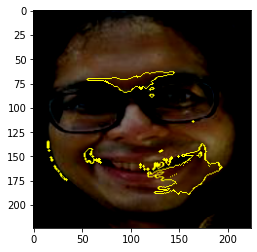

In [124]:
plt.imshow(img_boundry)